In [41]:
import os
import cv2 as cv
import ssl
import json
import base64
import http.client as httplib
import pandas as pd
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import time

In [42]:
headers = {"Content-type": "application/json",
           "X-Access-Token": "VfLe1Cnpc71kImp2CbIMMRsJh2TLSGtcXjMJ"}

In [43]:
color_names = {
    'Brown' : ['brown', 'beige', 'cream', 'beige/cream'],
    'Silver' : ['silver', 'grey', 'silver/grey'],
    'Blue' : ['blue'],
    'White' : ['white'],
    'Black' : ['black'],
    'Red' : ['red'],
    'Green' : ['green'],
    'Yellow' : ['yellow', 'orange'],
    'Orange' : ['Orange']
}

In [44]:
color_to_main = {
    'White' : 'White',
    'Blue' : 'Blue',
    'Silver' : 'Silver',
    'Black' : 'Black',
    'Grey' : 'Silver',
    'Sky blue' : 'Blue',
    'Red' : 'Red',
    'Beige' : 'Brown',
    'Green' : 'Green',
    'Yellow' : 'Yellow',
    'Brown' : 'Brown',
    'Orange' : 'Orange'
}

In [45]:
main_colors = ['White', 'Blue', 'Silver', 'Black', 'Red', 'Brown', 'Green', 'Yellow', 'Orange']

In [46]:
colors = ['White', 'Blue', 'Silver', 'Black',
        'Red', 'Green', 'Yellow', 'Brown', 'Orange']

In [47]:
request_number = 0

In [48]:
def plotting(path, x1, y1, x2, y2):
    print(x1, y1, x2, y2)
    src_image = cv.imread(path)
#     height, width = src_image.shape[:2]
    crop_image = src_image[y1:y2, x1:x2]
    
    cv.imwrite('./a.jpg', crop_image)
    plt.imshow(crop_image[:,:,::-1])
    
# plot_img('../my_data/img_data/car_imgs/'+'45732930/2.jpg')
# plot_img('../my_data/img_data/car_imgs/45626893/0.jpg')    

In [49]:
def plot_img(path):
    src_image = cv.imread(path)
    plt.imshow(src_image[:,:,::-1])

In [50]:
def create_connection():
    conn = httplib.HTTPSConnection("dev.sighthoundapi.com", 
        context=ssl.SSLContext(ssl.PROTOCOL_TLSv1_2))
    return conn

In [51]:
def get_box(path, color, conn):
    
    image_data = base64.b64encode(open(path, 'rb').read()).decode()
    params = json.dumps({"image": image_data})
    conn.request("POST", "/v1/recognition?objectType=vehicle", params, headers)
    response = conn.getresponse()
    result = response.read()
    json_obj = json.loads(result)
#     print(json_obj)
    if 'reasonCode' in json_obj and json_obj['reasonCode'] == 50202:
        print(json_obj)
        return 'TL'
    global request_number
    request_number += 1
    if not json_obj or 'objects' not in json_obj or len(json_obj['objects']) < 1:
        return False
    annot = json_obj['objects'][0]['vehicleAnnotation']
    if annot['recognitionConfidence'] < 0.70:
        return False
    
    col = annot['attributes']['system']['color']['name']
    conf = annot['attributes']['system']['color']['confidence']
    if (col in color_names[color]) and conf < .5:
        return False
    vertices = annot['bounding']['vertices']
    xy1 = vertices[0]
    xy3 = vertices[2]
    return xy1['x'], xy1['y'], xy3['x'], xy3['y']

# get_box('../my_data/img_data/car_imgs/45505633/2.jpg', 'White', create_connection())

In [52]:
def make_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [85]:
def get_images(IDs, color, conn):
    boxes = {}
    for ID in IDs:
        count = 2
        src = '../my_data/img_data/car_imgs/' + str(ID)
        dst = '../color_data3/' + str(ID)
        print(src)
        num_files = len([name for name in os.listdir('.') if os.path.isfile(name)])
        for i in range(num_files):
            img_src = src + '/' + str(i)
            if os.path.isfile(img_src+'.jpg'):
                img_src += '.jpg'
            elif os.path.isfile(img_src+'.png'):
                img_src += '.png'
            else:
                continue         
            
            resp = get_box(img_src, color, conn)
            if resp == 'TL':
                global request_number
                request_number = 0
                conn.close()
                print('Sleeping 5 min!!!!!!')
                countdown(5*60)
                conn = create_connection()
            elif resp:
                print('+', str(ID)+'/'+str(i))
                boxes[str(ID) + '/' + str(i)] = resp, color
                copyfile(img_src, dst+'.'+str(i)+'.jpg')
                count -= 1
            if count == 0:
                break
    return boxes
                    

In [14]:
df = pd.read_csv('../my_data/final.csv')
df.Color.unique()

array(['White', 'Blue', 'Silver', 'Black', nan, 'Grey', 'Carnelian red',
       'Sky blue', 'Red', 'Beige', 'Green', 'Yellow', 'Purple', 'Brown',
       'Golden', 'Orange', 'Pink',
       'ado  Prod. year 2018  CategoryPickup   Fuel type Diesel  Engine\xa0volume  2.8  Mileage 32685 km   Cylinders 4   Gear box typeAutomatic  Drive wheels  Doors 4/5       Wheel Left wheel  Color Black',
       'ado  Prod. year 2017  CategorySedan    Fuel type Petrol  Engine\xa0volume  3.6  Mileage 79093 km   Cylinders 6   Gear box typeAutomatic  Drive wheels Front  Doors 4/5       Wheel Left wheel  Color Blue'],
      dtype=object)

In [15]:
df.shape

(85937, 14)

In [78]:
dfs = []

In [80]:
for i, color in enumerate(colors):
    col_df = df.loc[df['Color'] == color]
    col_df = col_df.sample(n = 100, replace = True)
    col_df.to_csv('../chosedfs3/{}.csv'.format(color))
    dfs.append(col_df)

In [70]:
for i, color in enumerate(colors):
    col_df = pd.read_csv('../chosedfs2/{}.csv'.format(color))
    dfs.append(col_df)

In [133]:
dfs[1].head()

,Unnamed: 0,ID,Manufacturer,Model,Category,Mileage,Gear box type,Doors,Wheel,Color,Interior color,VIN,Leather interior,Price,Customs
0,11975,45656196,BMW,320 Diesel,Sedan,159000 km,Tiptronic,4/5,Left wheel,Blue,Black,NaN,1,11800,NaN
1,3134,45713196,MAZDA,323,Hatchback,236589 km,Manual,4/5,Left wheel,Blue,Grey,NaN,0,2000,NaN
2,15769,45753731,VOLKSWAGEN,Polo,Hatchback,194000 km,Manual,4/5,Left wheel,Blue,Black,NaN,0,1800,NaN
3,19399,45101783,LAND ROVER,Discovery,Jeep,135000 km,Tiptronic,4/5,Left wheel,Blue,Black,NaN,1,20000,917.0
4,2491,45715491,OPEL,Vectra,Sedan,126000 km,Manual,4/5,Left wheel,Blue,Black,NaN,0,Price negotiable,NaN


In [137]:
dfs[1].head()

,Unnamed: 0,ID,Manufacturer,Model,Category,Mileage,Gear box type,Doors,Wheel,Color,Interior color,VIN,Leather interior,Price,Customs
0,51275,45640728,SUBARU,Forester,Jeep,225685 km,Automatic,4/5,Left wheel,Blue,NaN,JF2SJARC5FH599028,1,Price negotiable,924.0
1,52461,45812216,LEXUS,GX 460,Jeep,192896 km,Automatic,4/5,Left wheel,Blue,Grey,JTJBT20X480157130,1,Price negotiable,2455.0
2,78057,45761450,BMW,X5 M,Jeep,65500 km,Automatic,4/5,Left wheel,Blue,Black,NaN,1,50000,NaN
3,59001,45776994,HYUNDAI,Elantra,Sedan,133502 km,Automatic,4/5,Left wheel,Blue,Beige,KMHDH4AE0EU183083,0,5500,584.0
4,79327,45652838,HYUNDAI,Sonata,Sedan,216208 km,Automatic,4/5,Left wheel,Blue,NaN,KMHEC4A48DA083274,1,375,751.0


In [140]:
c = dels

In [74]:
dels = []
for dff in dfs:
    dels += list(dff.ID)

In [151]:
print(len(set(c).intersection(set(dels))))

585


In [75]:
# df = df[df.ID not in dels]
for dell in dels:
    df = df[df.ID != dell]

In [82]:
df.shape

(85047, 14)

In [83]:
def countdown(t):
    while t:
        mins, secs = divmod(t, 60)
        timeformat = '{:02d}:{:02d}'.format(mins, secs)
        print(timeformat, end='\r')
        time.sleep(1)
        t -= 1
    print('Go API!\n\n\n\n\n')

In [86]:
boxes = {}
for i, color in enumerate(colors):
    col_df = dfs[i]
    IDs = list(col_df.ID)
    print('COLOR: ', color)
    start = time.time()
    conn = create_connection()
    col_boxes = get_images(IDs, color_to_main[color], conn)
    with open('./thirdtry/boxes_{}.json'.format(color), 'w') as f:
        json.dump(col_boxes, f)
        
    boxes = {**boxes, **col_boxes}
    end = time.time()
    print(end-start, len(boxes))

with open('./thirdtry/boxes.json', 'w') as f:
    json.dump(boxes, f)

COLOR:  White
../my_data/img_data/car_imgs/45769334
+ 45769334/0
+ 45769334/1
../my_data/img_data/car_imgs/45780889
+ 45780889/0
+ 45780889/1
../my_data/img_data/car_imgs/45629171
+ 45629171/0
+ 45629171/1
../my_data/img_data/car_imgs/42307283
+ 42307283/0
+ 42307283/1
../my_data/img_data/car_imgs/45812984
+ 45812984/0
+ 45812984/2
../my_data/img_data/car_imgs/45821863
+ 45821863/0
+ 45821863/1
../my_data/img_data/car_imgs/45799296
+ 45799296/0
+ 45799296/1
../my_data/img_data/car_imgs/45815812
+ 45815812/0
+ 45815812/3
../my_data/img_data/car_imgs/45782400
+ 45782400/0
+ 45782400/1
../my_data/img_data/car_imgs/45619655
../my_data/img_data/car_imgs/45781525
+ 45781525/0
+ 45781525/1
../my_data/img_data/car_imgs/45806949
../my_data/img_data/car_imgs/45786041
+ 45786041/0
+ 45786041/3
../my_data/img_data/car_imgs/45804712
+ 45804712/0
+ 45804712/1
../my_data/img_data/car_imgs/45754049
+ 45754049/0
+ 45754049/3
../my_data/img_data/car_imgs/45769000
+ 45769000/0
+ 45769000/1
../my_data/img

+ 45615371/1
../my_data/img_data/car_imgs/45586646
+ 45586646/0
+ 45586646/1
../my_data/img_data/car_imgs/45481099
+ 45481099/0
+ 45481099/1
../my_data/img_data/car_imgs/45800910
+ 45800910/1
+ 45800910/2
../my_data/img_data/car_imgs/45817555
+ 45817555/0
../my_data/img_data/car_imgs/45682464
+ 45682464/0
+ 45682464/2
../my_data/img_data/car_imgs/45702515
+ 45702515/0
+ 45702515/1
../my_data/img_data/car_imgs/45808120
+ 45808120/0
{'error': 'ERROR_OVER_THROTTLE', 'reason': 'Please wait for a while', 'reasonCode': 50202}
Sleeping 5 min!!!!!!
Go API!





../my_data/img_data/car_imgs/45744805
+ 45744805/0
+ 45744805/1
../my_data/img_data/car_imgs/45747155
+ 45747155/0
+ 45747155/2
../my_data/img_data/car_imgs/45818389
+ 45818389/0
+ 45818389/1
../my_data/img_data/car_imgs/45811902
+ 45811902/0
+ 45811902/1
../my_data/img_data/car_imgs/45758493
+ 45758493/3
+ 45758493/4
../my_data/img_data/car_imgs/45817149
+ 45817149/0
+ 45817149/1
../my_data/img_data/car_imgs/45663718
+ 45663718/0
+ 456

../my_data/img_data/car_imgs/45815500
../my_data/img_data/car_imgs/45768932
../my_data/img_data/car_imgs/45639911
../my_data/img_data/car_imgs/45731015
../my_data/img_data/car_imgs/45815517
../my_data/img_data/car_imgs/45805667
../my_data/img_data/car_imgs/45732787
../my_data/img_data/car_imgs/45798089
../my_data/img_data/car_imgs/45758435
../my_data/img_data/car_imgs/45768273
../my_data/img_data/car_imgs/45821249
../my_data/img_data/car_imgs/45620692
../my_data/img_data/car_imgs/45794002
../my_data/img_data/car_imgs/45818386
../my_data/img_data/car_imgs/45635328
../my_data/img_data/car_imgs/45760181
../my_data/img_data/car_imgs/45795450
../my_data/img_data/car_imgs/45635355
../my_data/img_data/car_imgs/45791817
../my_data/img_data/car_imgs/45646618
../my_data/img_data/car_imgs/45639203
../my_data/img_data/car_imgs/45819677
../my_data/img_data/car_imgs/45766027
../my_data/img_data/car_imgs/45730103
../my_data/img_data/car_imgs/45709546
../my_data/img_data/car_imgs/45577139
../my_data/i

../my_data/img_data/car_imgs/44962348
../my_data/img_data/car_imgs/42166133
../my_data/img_data/car_imgs/45805587
../my_data/img_data/car_imgs/45551345
../my_data/img_data/car_imgs/45786348
../my_data/img_data/car_imgs/45799852
../my_data/img_data/car_imgs/45635242
../my_data/img_data/car_imgs/45764544
../my_data/img_data/car_imgs/45788888
../my_data/img_data/car_imgs/45769157
../my_data/img_data/car_imgs/45770023
../my_data/img_data/car_imgs/45785622
../my_data/img_data/car_imgs/45815193
../my_data/img_data/car_imgs/44106073
../my_data/img_data/car_imgs/45808501
../my_data/img_data/car_imgs/45696806
../my_data/img_data/car_imgs/45812228
../my_data/img_data/car_imgs/45634835
../my_data/img_data/car_imgs/45639222
../my_data/img_data/car_imgs/45819957
../my_data/img_data/car_imgs/45820337
../my_data/img_data/car_imgs/45755040
../my_data/img_data/car_imgs/45790558
../my_data/img_data/car_imgs/45797235
../my_data/img_data/car_imgs/45643548
../my_data/img_data/car_imgs/45720321
../my_data/i

../my_data/img_data/car_imgs/45698753
../my_data/img_data/car_imgs/45801169
../my_data/img_data/car_imgs/45799885
../my_data/img_data/car_imgs/45591071
../my_data/img_data/car_imgs/45784927
../my_data/img_data/car_imgs/45613759
../my_data/img_data/car_imgs/45637279
../my_data/img_data/car_imgs/45739802
../my_data/img_data/car_imgs/45593314
../my_data/img_data/car_imgs/45785296
../my_data/img_data/car_imgs/45791709
../my_data/img_data/car_imgs/45746028
../my_data/img_data/car_imgs/45781343
../my_data/img_data/car_imgs/45814409
../my_data/img_data/car_imgs/45817350
../my_data/img_data/car_imgs/45821511
../my_data/img_data/car_imgs/45774341
../my_data/img_data/car_imgs/45731886
../my_data/img_data/car_imgs/45644362
../my_data/img_data/car_imgs/45772538
../my_data/img_data/car_imgs/45593762
../my_data/img_data/car_imgs/45765647
../my_data/img_data/car_imgs/45822006
../my_data/img_data/car_imgs/45639245
../my_data/img_data/car_imgs/45655297
../my_data/img_data/car_imgs/45625767
../my_data/i

In [130]:
conn.close()

In [58]:
for i, color in enumerate(colors[:2]):
    with open('boxes_{}.json'.format(color), "r") as read_file:
        col_json = json.load(read_file)
        boxes = {**col_json, **boxes}
#         print(type(col_json))

In [109]:
with open('./secondtry/finally_boxes.json', 'w') as f:
    json.dump(boxes, f)

In [30]:
print(len(boxes))

655


((87, 53, 248, 197), 'Silver')
87 53 248 197


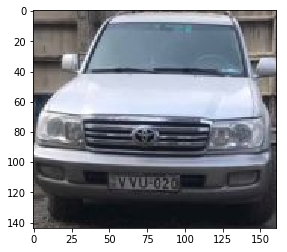

In [71]:
print(boxes['45660870/1'])
plotting('../color_data/45660870.1.jpg', *boxes['45660870/1'][0])

In [31]:
dic = {}
for name, box in boxes.items():
    if box[1] not in dic:
        dic[box[1]] = 0
    dic[box[1]] += 1

In [32]:
dic

{'White': 74,
 'Blue': 68,
 'Silver': 77,
 'Black': 74,
 'Red': 87,
 'Green': 68,
 'Yellow': 45,
 'Brown': 75,
 'Orange': 87}

In [61]:
with open('./firsttry/finally_boxes.json', "r") as read_file:
    boxes_last1 = json.load(read_file)

In [62]:
with open('./secondtry/boxes.json', "r") as read_file:
    boxes_last2 = json.load(read_file)

In [63]:
final = {**boxes_last1, **boxes_last2}
len(final)

1652

In [66]:
with open('./finally_boxes.json', 'w') as f:
    json.dump(final, f)

In [67]:
len(final)

1652